In [2]:
import warnings

warnings.filterwarnings('ignore')

In [1]:
import pandas as pd
import os
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

# ---------------------------------------------------------
# 1. 환경변수 로드 (notebooks 폴더의 상위 폴더에 있는 .env 로드)
# ---------------------------------------------------------
load_dotenv(dotenv_path="../.env")

# 2. DB 연결
DB_CONFIG = {
    "host": os.getenv("DB_HOST"),
    "port": int(os.getenv("DB_PORT", 3306)),
    "user": os.getenv("DB_USER", "admin"),
    "password": os.getenv("DB_PASSWORD"),
    "db": os.getenv("DB_NAME", "projectl")
}

db_url = f"mysql+pymysql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['db']}"
engine = create_engine(db_url)
print("✅ DB 연결 성공!")

# ---------------------------------------------------------
# 3. 데이터 수집 함수 (스키마 컬럼명 수정 완료)
# ---------------------------------------------------------
def get_item_data(item_name):
    conn = engine.connect()
    try:
        # (1) 아이템 ID 찾기
        item_sql = text("SELECT id FROM market_items WHERE name = :name")
        item_id = conn.execute(item_sql, {"name": item_name}).scalar()
        
        if not item_id:
            print(f"❌ '{item_name}' 아이템을 찾을 수 없습니다.")
            return None, None

        print(f"🔍 '{item_name}' (ID: {item_id}) 데이터 수집 중...")

        # (2) 가격 로그 가져오기 (컬럼명: current_min_price, logged_at)
        price_sql = text("""
            SELECT logged_at, current_min_price
            FROM market_price_logs
            WHERE item_id = :item_id
            ORDER BY logged_at ASC
        """)
        df_prices = pd.read_sql(price_sql, conn, params={"item_id": item_id})
        
        # (3) GPT Score 가져오기 (컬럼명: notice_date, gpt_score)
        notice_sql = text("""
            SELECT r.notice_date, i.gpt_score
            FROM item_notice_impacts i
            JOIN raw_notices r ON i.notice_id = r.id
            WHERE i.item_id = :item_id
            ORDER BY r.notice_date ASC
        """)
        df_notices = pd.read_sql(notice_sql, conn, params={"item_id": item_id})
        
        print(f"   - 가격 로그: {len(df_prices)}개")
        print(f"   - 관련 공지: {len(df_notices)}개")
        
        return df_prices, df_notices

    finally:
        conn.close()

# ---------------------------------------------------------
# [테스트] 아이템 이름 입력
# ---------------------------------------------------------
TARGET_ITEM = "운명의 파괴석"  # 👈 분석하고 싶은 아이템 이름
df_raw, df_gpt = get_item_data(TARGET_ITEM)

display(df_raw.head())
display(df_gpt.head())

✅ DB 연결 성공!
🔍 '운명의 파괴석' (ID: 66102006) 데이터 수집 중...
   - 가격 로그: 6912개
   - 관련 공지: 8개


,logged_at,current_min_price
0,2025-12-18 11:00:10.958607,99
1,2025-12-18 11:10:47.801668,100
2,2025-12-18 11:21:26.091468,98
3,2025-12-18 11:32:02.106706,100
4,2025-12-18 11:42:37.977318,98


,notice_date,gpt_score
0,2025-12-17,0.0
1,2025-12-24,0.0
2,2025-12-31,0.0
3,2026-01-07,0.5
4,2026-01-14,0.0


In [3]:
import numpy as np
from datetime import timedelta

# =========================================================
# [업그레이드] 함수 1: 원본 청소 후 30분봉 만들기
# =========================================================
def preprocess_ohlc_and_fill(df_raw):
    print("🧹 [1단계] Raw 데이터 정제 및 30분봉 변환...")
    
    df = df_raw.copy()
    
    # 1. 인덱스 설정 (필수)
    if 'logged_at' in df.columns:
        df['logged_at'] = pd.to_datetime(df['logged_at'])
        df.set_index('logged_at', inplace=True)

    # -----------------------------------------------------
    # 🚨 [핵심 추가] 원본(10분 단위) 단계에서 이상치 1차 제거
    # -----------------------------------------------------
    # 10분 데이터이므로 하루(24시간)를 보려면 window가 약 144개 필요합니다.
    # (6개/시간 * 24시간 = 144)
    raw_window = 432
    raw_sigma = 7 # 원본은 변동성이 더 크니 2.0보다 살짝 여유 있게 2.5 추천
    
    # 원본 가격 컬럼: 'current_min_price'
    rolling_mean = df['current_min_price'].rolling(window=raw_window, center=True).mean()
    rolling_std = df['current_min_price'].rolling(window=raw_window, center=True).std()
    
    upper = rolling_mean + (raw_sigma * rolling_std)
    lower = rolling_mean - (raw_sigma * rolling_std)
    
    outliers = (df['current_min_price'] > upper) | (df['current_min_price'] < lower)
    cnt = outliers.sum()
    
    if cnt > 0:
        print(f"   ✨ 원본 데이터에서 {cnt}개의 이상치를 미리 제거했습니다!")
        df.loc[outliers, 'current_min_price'] = np.nan
        df['current_min_price'] = df['current_min_price'].interpolate(method='linear')
    # -----------------------------------------------------
    
    # 2. 30분 단위 Resampling (이제 깨끗한 재료로 요리합니다)
    df_resampled = df['current_min_price'].resample('30min').agg(['first', 'max', 'min', 'last', 'mean'])
    df_resampled.columns = ['Open', 'High', 'Low', 'Close', 'Price_Mean']
    
    # 3. 빈칸 채우기
    df_filled = df_resampled.ffill().bfill()
    
    print(f"   - 정제 완료: {len(df_filled)}개 구간 (30분봉)")
    return df_filled

# =========================================================
# [추가됨] 함수 1.5: 이상치 제거 (Rolling Z-Score)
# =========================================================
def clean_outliers_rolling(df, column='Close', window=48, sigma=3):
    print(f"🧼 [1.5단계] 이상치 제거 중... (Window={window}, Sigma={sigma})")
    df_clean = df.copy()
    
    # 이동 평균과 표준편차 계산
    rolling_mean = df_clean[column].rolling(window=window, center=True).mean()
    rolling_std = df_clean[column].rolling(window=window, center=True).std()
    
    # 이상치 판별 기준
    upper_bound = rolling_mean + (sigma * rolling_std)
    lower_bound = rolling_mean - (sigma * rolling_std)
    
    # 이상치 조건 확인 및 개수 카운트
    outlier_mask = (df_clean[column] > upper_bound) | (df_clean[column] < lower_bound)
    outlier_count = outlier_mask.sum()
    
    if outlier_count > 0:
        print(f"   🚨 {outlier_count}개의 튀는 가격 발견! 부드럽게 보정합니다.")
        # 이상치를 NaN으로 변경 후 보간(Interpolation)
        df_clean.loc[outlier_mask, column] = np.nan
        df_clean[column] = df_clean[column].interpolate(method='linear')
    else:
        print("   ✅ 데이터가 아주 깨끗합니다.")
        
    return df_clean

# =========================================================
# 함수 2: GPT 스코어 매핑 (날짜 계산 로직)
# =========================================================
def apply_gpt_scores(df_price, df_gpt):
    print("🤖 [2단계] GPT 공지사항 점수 매핑 중...")
    
    df = df_price.copy()
    df['GPT_Score'] = 0.0 # 기본값 0
    
    if df_gpt is None or df_gpt.empty:
        print("   - 공지사항 데이터가 없습니다. (점수 0으로 진행)")
        return df

    count = 0
    for idx, row in df_gpt.iterrows():
        notice_date = pd.to_datetime(row['notice_date'])
        score = row['gpt_score']
        
        # [규칙 적용] 공지일 10:00 ~ 7일 뒤 06:00
        start_time = notice_date.replace(hour=10, minute=0, second=0)
        end_time = (notice_date + timedelta(days=7)).replace(hour=6, minute=0, second=0)
        
        # 해당 기간 마스킹
        mask = (df.index >= start_time) & (df.index < end_time)
        
        if mask.any():
            df.loc[mask, 'GPT_Score'] = score
            count += 1
            
    print(f"   - 총 {count}건의 공지사항 점수 반영 완료")
    return df

# =========================================================
# [실행] 파이프라인 연결 (순서 중요!)
# =========================================================

# 1. 가격 데이터 1차 정제 (빈칸 채우기)
df_temp = preprocess_ohlc_and_fill(df_raw)

# 2. [추가] 이상치 제거 (여기서 튀는 값을 잡습니다!)
df_clean_price = clean_outliers_rolling(df_temp, column='Price_Mean', window=48, sigma=3)

# 3. GPT 점수 결합
df_final = apply_gpt_scores(df_clean_price, df_gpt)

# 4. 결과 확인
print("-" * 30)
print(f"🗓️ 데이터 기간: {df_final.index.min()} ~ {df_final.index.max()}")
print("-" * 30)
display(df_final.tail())

🧹 [1단계] Raw 데이터 정제 및 30분봉 변환...
   ✨ 원본 데이터에서 1개의 이상치를 미리 제거했습니다!
   - 정제 완료: 2398개 구간 (30분봉)
🧼 [1.5단계] 이상치 제거 중... (Window=48, Sigma=3)
   🚨 2개의 튀는 가격 발견! 부드럽게 보정합니다.
🤖 [2단계] GPT 공지사항 점수 매핑 중...
   - 총 8건의 공지사항 점수 반영 완료
------------------------------
🗓️ 데이터 기간: 2025-12-18 11:00:00 ~ 2026-02-06 09:30:00
------------------------------


,Open,High,Low,Close,Price_Mean,GPT_Score
logged_at,,,,,,
2026-02-06 07:30:00,325.0,329.0,321.0,321.0,325.000000,0.0
2026-02-06 08:00:00,316.0,323.0,307.0,323.0,315.333333,0.0
2026-02-06 08:30:00,334.0,348.0,334.0,348.0,340.333333,0.0
2026-02-06 09:00:00,349.0,349.0,307.0,328.0,328.000000,0.0
2026-02-06 09:30:00,319.0,324.0,319.0,324.0,321.500000,0.0


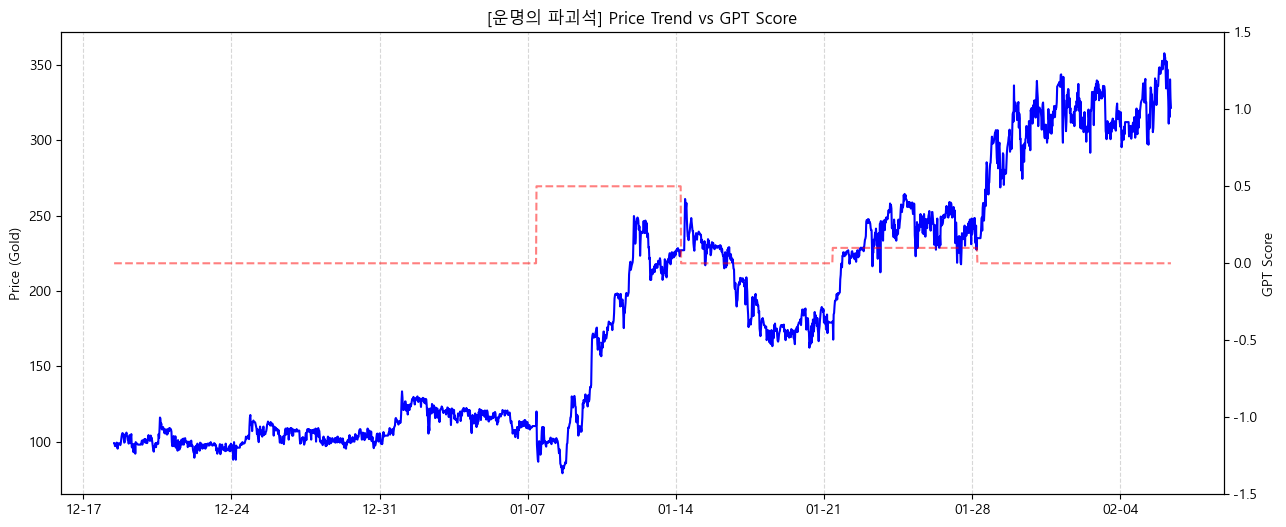

,Open,High,Low,Close,Price_Mean,GPT_Score
logged_at,,,,,,
2026-02-06 07:30:00,325.0,329.0,321.0,321.0,325.000000,0.0
2026-02-06 08:00:00,316.0,323.0,307.0,323.0,315.333333,0.0
2026-02-06 08:30:00,334.0,348.0,334.0,348.0,340.333333,0.0
2026-02-06 09:00:00,349.0,349.0,307.0,328.0,328.000000,0.0
2026-02-06 09:30:00,319.0,324.0,319.0,324.0,321.500000,0.0


In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ---------------------------------------------------------
# 3. 시각화 (확인용)
# ---------------------------------------------------------
plt.figure(figsize=(15, 6))

# 가격 그래프 (파란색)
ax1 = plt.gca()
ax1.plot(df_final.index, df_final['Price_Mean'], color='blue', label='Avg Price')
ax1.set_ylabel('Price (Gold)')

# GPT 점수 그래프 (빨간색, y축 공유)
ax2 = ax1.twinx()
ax2.plot(df_final.index, df_final['GPT_Score'], color='red', linestyle='--', alpha=0.5, label='GPT Score')
ax2.set_ylabel('GPT Score')
ax2.set_ylim(-1.5, 1.5)

# 2. 눈금 형식: '월-일' 형태로 보여줘라 (예: 01-29)
# 연도까지 보고 싶으면 '%Y-%m-%d'로 바꾸시면 됩니다.
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WEDNESDAY, interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax1.grid(True, which='major', axis='x', linestyle='--', alpha=0.5) # 수요일마다 세로 점선 추가

plt.title(f"[{TARGET_ITEM}] Price Trend vs GPT Score")
plt.show()

# 데이터 확인
display(df_final.tail())

In [5]:
import torch
import pandas as pd
from neuralprophet import NeuralProphet, save, set_random_seed

# ---------------------------------------------------------
# 1. 설정 및 데이터 준비
# ---------------------------------------------------------
set_random_seed(42)

# PyTorch 보안 해제 (학습 시엔 필요 없지만 습관적으로 넣어두면 안전)
_original_torch_load = torch.load
def patched_torch_load(*args, **kwargs):
    if 'weights_only' not in kwargs:
        kwargs['weights_only'] = False
    return _original_torch_load(*args, **kwargs)
torch.load = patched_torch_load

# 데이터 준비 (오전 6시 이전)
train_cutoff = pd.to_datetime("2026-02-04 06:00:00")
df_np = df_final.reset_index()[['logged_at', 'Close', 'GPT_Score']].copy()
df_np.columns = ['ds', 'y', 'GPT_Score']
df_train = df_np[df_np['ds'] < train_cutoff]

print("✅ NeuralProphet용 데이터 준비 완료")
display(df_np.tail())

✅ NeuralProphet용 데이터 준비 완료


,ds,y,GPT_Score
2393,2026-02-06 07:30:00,321.0,0.0
2394,2026-02-06 08:00:00,323.0,0.0
2395,2026-02-06 08:30:00,348.0,0.0
2396,2026-02-06 09:00:00,328.0,0.0
2397,2026-02-06 09:30:00,324.0,0.0


In [10]:
# ---------------------------------------------------------
# 2. 모델 정의
# ---------------------------------------------------------
def NeuralProphet_fit(FORECAST_HORIZON):
    m = NeuralProphet(
        n_forecasts=FORECAST_HORIZON,
        n_lags=240,
        
        n_changepoints=10,
        trend_reg=1.0,
        weekly_seasonality=True, # 수요일 점검 등의 주간 패턴 학습
        daily_seasonality=True,  # 새벽/저녁 패턴 학습
        yearly_seasonality=False,# 1년치 데이터는 아니므로 끔
        learning_rate=0.01,
        growth='off'
    )

    # 3. GPT 점수(공지사항)를 '미래를 아는 변수'로 추가
    # (우리가 미래 공지사항은 없다고(0) 가정하고 입력할 것이기 때문)
    m.add_future_regressor("GPT_Score")

    # ---------------------------------------------------------
    # 3. 재학습 및 저장
    # ---------------------------------------------------------
    print(f"🧠 [3일 단기 속성반] 모델 학습 시작... (목표: {FORECAST_HORIZON}스텝)")

    # 학습 (보안 옵션 적용)
    m.fit(df_train, freq="30min", num_workers=0, checkpointing=False)

    # 모델 덮어쓰기
    model_filename = "lostark_price_model.np"
    save(m, model_filename)

    print(f"✅ 최적화된 모델 저장 완료: {model_filename}")
    print("   이제 이 모델은 '3일 뒤'까지만 예측하지만, 그만큼 더 정교할 겁니다!")

FORECAST_HORIZON = 144
NeuralProphet_fit(FORECAST_HORIZON)

INFO - (NP.config.__post_init__) - Trend reg lambda ignored due to no changepoints.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency 30min corresponds to 99.956% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30min
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90


🧠 [3일 단기 속성반] 모델 학습 시작... (목표: 144스텝)


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

✅ 최적화된 모델 저장 완료: lostark_price_model.np
   이제 이 모델은 '3일 뒤'까지만 예측하지만, 그만큼 더 정교할 겁니다!


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from neuralprophet import load

# ---------------------------------------------------------
# [필수] 1. PyTorch 2.6 보안 잠금 해제 (마스터키)
# ---------------------------------------------------------
# 저장된 모델을 불러올 때 에러가 나지 않도록 하는 안전장치입니다.
# _original_torch_load = torch.load
# def patched_torch_load(*args, **kwargs):
#     if 'weights_only' not in kwargs:
#         kwargs['weights_only'] = False
#     return _original_torch_load(*args, **kwargs)
# torch.load = patched_torch_load

# ---------------------------------------------------------
# 2. 저장된 모델 불러오기 (Load)
# ---------------------------------------------------------
print("📂 [3일 예측 전용] 모델을 불러오는 중...")
# 아까 저장한 파일명 (lostark_price_model.np)
loaded_model = load("lostark_price_model.np")
print("✅ 모델 로딩 완료! (학습 과정 없이 바로 예측 가능)")

📂 [3일 예측 전용] 모델을 불러오는 중...


Training: |          | 0/? [00:00<?, ?it/s]

✅ 모델 로딩 완료! (학습 과정 없이 바로 예측 가능)


In [12]:
# ---------------------------------------------------------
# 3. '현재(Now)' 설정 및 최신 데이터 준비
# ---------------------------------------------------------
# [실전용] 서버에서는 아래 코드를 주석 해제해서 쓰세요!
current_now = pd.Timestamp.now()

# 전체 데이터 중 '현재 시간(Now) 이전'의 데이터만 잘라서 가져옵니다.
df_recent = df_np[df_np['ds'] <= current_now].copy()

INFO - (NP.df_utils._infer_frequency) - Major frequency 30min corresponds to 99.958% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30min
WARNING - (NP.df_utils.check_dataframe) - Encountered future regressor with only unique values in training set across all IDs.Automatically removed variable.
WARNING - (NP.data.processing._check_dataframe) - Removing regressor GPT_Score because it is not present in the data.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 30min corresponds to 99.74% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30min
INFO - (NP.df_utils._infer_frequency) - Major frequency 30min corresponds to 99.74% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30min
INFO - (NP.data.processing._handle_missing_data) - Dropped 144 rows

🔮 지금(2026-02-06 09:47:48.820049)부터 향후 3일간 예측 데이터 추출 중...


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


✅ NaN 해결 완료! 이제 숫자가 꽉 차 있습니다.


,날짜,예측가격
0,2026-02-06 10:00:00,341.188782
1,2026-02-06 10:30:00,332.492432
2,2026-02-06 11:00:00,331.087158
3,2026-02-06 11:30:00,320.805176
4,2026-02-06 12:00:00,356.338684
5,2026-02-06 12:30:00,348.193329
6,2026-02-06 13:00:00,340.655182
7,2026-02-06 13:30:00,329.459961
8,2026-02-06 14:00:00,334.229065
9,2026-02-06 14:30:00,331.532043


,날짜,예측가격
139,2026-02-09 07:30:00,372.810242
140,2026-02-09 08:00:00,385.709351
141,2026-02-09 08:30:00,376.320160
142,2026-02-09 09:00:00,378.953888
143,2026-02-09 09:30:00,397.754822


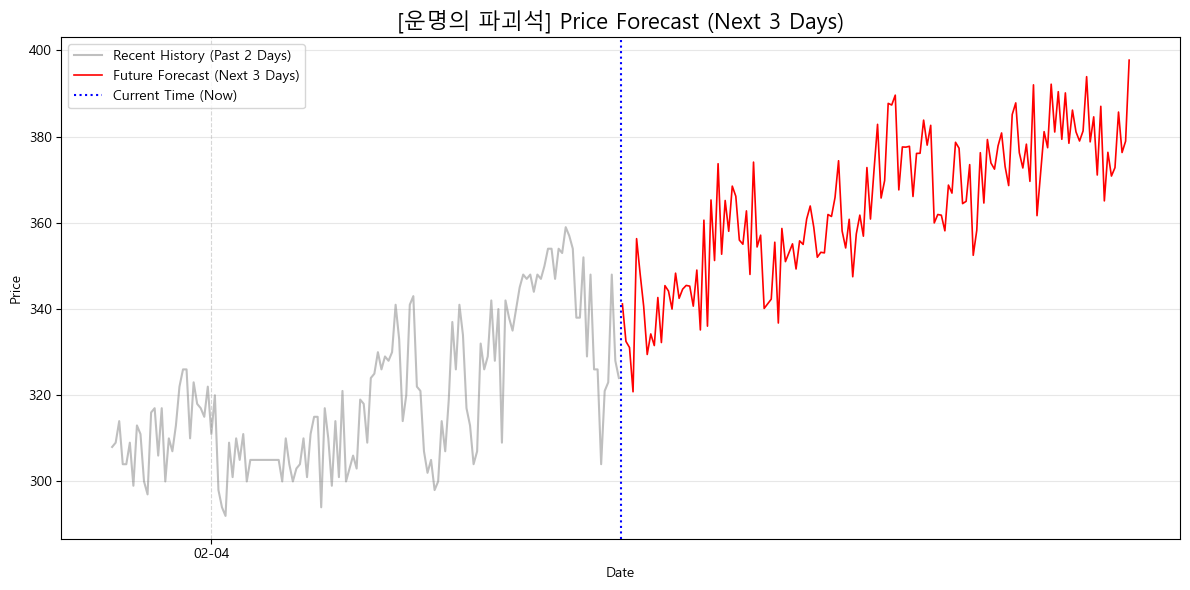


📊 [3일 단기 예측 리포트]
   - 예측 구간: 2026-02-06 10:00:00 ~ 2026-02-09 09:30:00
   - 예상 최저가: 321 G
   - 예상 최고가: 398 G
   - 3일 뒤 마감: 398 G


In [13]:
# ---------------------------------------------------------
# 4. 미래 3일 예측 준비
# ---------------------------------------------------------
# 예측 기간: 3일 * 24시간 * 2 (30분 단위) = 144개
forecast_steps = 144

# 미래 GPT 점수(공지사항) 준비 (3일치 = 144개)
# (만약 내일 점검 공지가 있다면 여기에 점수를 넣어주면 됩니다)
future_regressors = pd.DataFrame(data={'GPT_Score': [0.0] * forecast_steps})

# [핵심] df_recent(과거~현재)를 넣어주면, 자동으로 '현재' 이후의 날짜를 만들어줍니다.
future = loaded_model.make_future_dataframe(
    df_recent,
    periods=forecast_steps,
    n_historic_predictions=False,
    regressors_df=future_regressors
)

# ---------------------------------------------------------
# 5. [진짜 최종] 대각선 추출법으로 NaN 완벽 해결
# ---------------------------------------------------------
print(f"🔮 지금({current_now})부터 향후 3일간 예측 데이터 추출 중...")

# 1. 예측 실행
forecast = loaded_model.predict(future)

# 2. 미래 날짜 행들만 따로 모읍니다. (y가 NaN인 구간)
future_rows = forecast[forecast['y'].isnull()].copy()

# 3. 각 행에서 자신의 위치(i번째 미래)에 맞는 yhat{i} 값을 뽑습니다.
# 예: 1번째 미래 행에선 yhat1, 144번째 미래 행에선 yhat144를 가져옴
valid_preds = []
for i in range(1, len(future_rows) + 1):
    row_idx = future_rows.index[i-1]
    col_name = f'yhat{i}'
    valid_preds.append(future_rows.loc[row_idx, col_name])

# 4. 이제 NaN 없는 깨끗한 데이터프레임 생성!
forecast_3days = pd.DataFrame({
    '날짜': future_rows['ds'].values,
    '예측가격': valid_preds
})

print("✅ NaN 해결 완료! 이제 숫자가 꽉 차 있습니다.")
display(forecast_3days.head(10))
display(forecast_3days.tail(5)) # 포린님이 말씀하신 그 마지막 행의 값 확인!

# ---------------------------------------------------------
# 6. 결과 시각화
# ---------------------------------------------------------
plt.figure(figsize=(12, 6))

# (1) 최신 흐름 (Now 기준 과거 2일치만 보여주기)
recent_view = df_recent.tail(144)
plt.plot(recent_view['ds'], recent_view['y'], label='Recent History (Past 2 Days)', color='gray', alpha=0.5)

# (2) 3일 뒤 예측선 (Now ~ Future)
plt.plot(forecast_3days['날짜'], forecast_3days['예측가격'], label='Future Forecast (Next 3 Days)', color='red', linewidth=1.2)

# 기준선 (Now)
plt.axvline(current_now, color='blue', linestyle=':', label='Current Time (Now)')

# 스타일 설정
plt.title(f"[{TARGET_ITEM}] Price Forecast (Next 3 Days)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)

# X축 날짜 포맷
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WEDNESDAY, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.grid(True, which='major', axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 7. 요약 리포트
# ---------------------------------------------------------
min_p = forecast_3days['예측가격'].min()
max_p = forecast_3days['예측가격'].max()
last_p = forecast_3days['예측가격'].iloc[-1]

print(f"\n📊 [3일 단기 예측 리포트]")
print(f"   - 예측 구간: {forecast_3days['날짜'].iloc[0]} ~ {forecast_3days['날짜'].iloc[-1]}")
print(f"   - 예상 최저가: {min_p:.0f} G")
print(f"   - 예상 최고가: {max_p:.0f} G")
print(f"   - 3일 뒤 마감: {last_p:.0f} G")

📂 모델 로딩 및 미끼(Dummy) 데이터 준비 중...


Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency 30min corresponds to 99.961% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30min
INFO - (NP.df_utils._infer_frequency) - Major frequency 30min corresponds to 99.961% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30min
INFO - (NP.data.processing._handle_missing_data) - Dropped 144 rows at the end with NaNs in 'y' column.


   - 원본 데이터 끝: 2026-02-06 09:30:00
   - 미끼 투척 완료! (총 데이터 길이: 2398 -> 2542)
🔮 예측 수행 중... (이제 잘라먹혀도 안전함)


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


✅ 검증 데이터 확보: 65개 (성공!)
------------------------------------------------------------
🧠 [NeuralProphet 성적표 (2/4 ~ 현재)]
   - RMSE: 12.82
   - MAE : 10.50
   - MAPE: 3.37%
   - r2  : -0.05
   - Dir Acc: 39.1%
------------------------------------------------------------


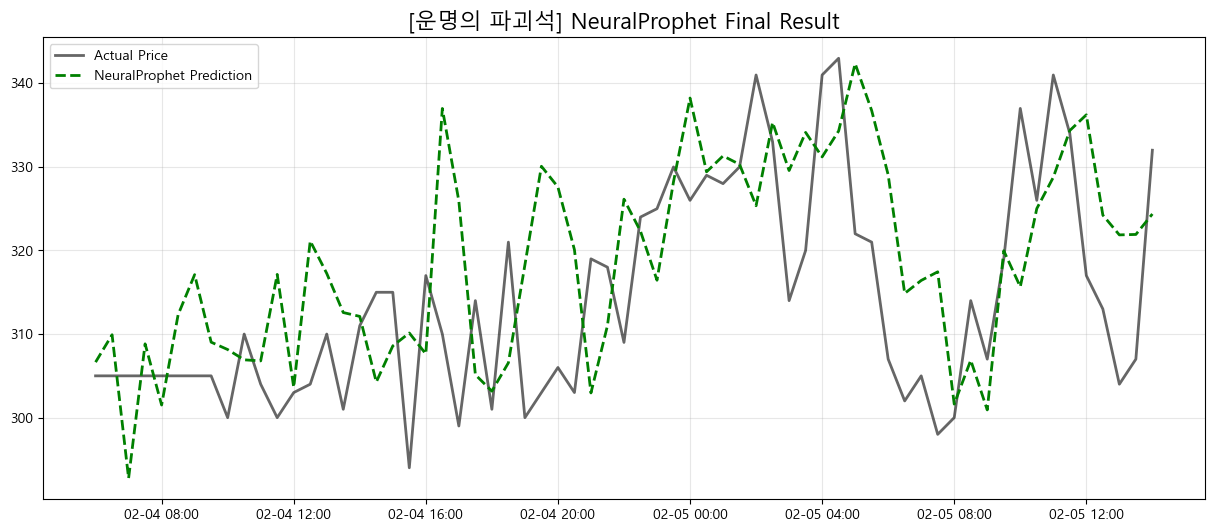

In [14]:
from neuralprophet import load
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# =========================================================
# 1. 평가 함수 (LightGBM과 동일)
# =========================================================
def get_detailed_score(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-7))) * 100
    r2 = r2_score(y_true, y_pred)
    
    true_diff = np.diff(y_true)
    pred_diff = np.diff(y_pred)
    dir_acc = (np.sum(np.sign(true_diff) == np.sign(pred_diff)) / len(true_diff)) * 100
    return rmse, mae, mape, r2, dir_acc

# =========================================================
# 2. 모델 로드 및 데이터 준비
# =========================================================
print("📂 모델 로딩 및 미끼(Dummy) 데이터 준비 중...")
try:
    m = load("lostark_price_model.np")
except:
    m = None

if m:
    # (1) 원본 데이터 준비
    df_np = df_final.reset_index().rename(columns={'logged_at': 'ds', 'Close': 'y'})
    df_np = df_np[['ds', 'y', 'GPT_Score']]
    df_np['ds'] = pd.to_datetime(df_np['ds'])
    df_np['GPT_Score'] = df_np['GPT_Score'].fillna(0.0)

    # (2) ★ [핵심 전략] 미끼 데이터(Dummy) 144개 생성
    last_date = df_np['ds'].max()
    print(f"   - 원본 데이터 끝: {last_date}")
    
    # 30분 간격으로 미래 144개(3일치) 날짜 생성
    future_dates = pd.date_range(start=last_date + pd.Timedelta(minutes=30), periods=144, freq='30min')
    
    # 미끼 데이터프레임
    df_dummy = pd.DataFrame({
        'ds': future_dates,
        'y': np.nan,         # 가격은 모름 (상관없음)
        'GPT_Score': 0.0     # 미래 공지 없음으로 가정
    })
    
    # (3) 원본 + 미끼 합치기
    df_extended = pd.concat([df_np, df_dummy], ignore_index=True)
    print(f"   - 미끼 투척 완료! (총 데이터 길이: {len(df_np)} -> {len(df_extended)})")

    # =========================================================
    # 3. 예측 수행 (Extended 데이터로)
    # =========================================================
    print("🔮 예측 수행 중... (이제 잘라먹혀도 안전함)")
    
    # 여기서 모델이 뒤쪽 144개를 잘라먹지만, 그건 우리가 만든 '미끼'입니다.
    forecast = m.predict(df_extended)
    
    # =========================================================
    # 4. 검증 데이터 추출 (2월 4일 ~ 원본 끝)
    # =========================================================
    cutoff = pd.to_datetime("2026-02-04 06:00:00")
    real_end = pd.to_datetime("2026-02-05 14:00:00") # 포린님 데이터 끝 시점
    
    # 미끼 부분은 제외하고, 진짜 데이터 구간만 필터링
    mask = (forecast['ds'] >= cutoff) & (forecast['ds'] <= real_end)
    df_valid = forecast[mask].copy()
    
    # NaN 제거
    df_valid = df_valid.dropna(subset=['y', 'yhat1'])
    
    print(f"✅ 검증 데이터 확보: {len(df_valid)}개 (성공!)")

    # =========================================================
    # 5. 성적표 출력
    # =========================================================
    if len(df_valid) > 0:
        y_true = df_valid['y'].values
        y_pred = df_valid['yhat1'].values
        
        rmse, mae, mape, r2, dir_acc = get_detailed_score(y_true, y_pred)

        print("-" * 60)
        print(f"🧠 [NeuralProphet 성적표 (2/4 ~ 현재)]")
        print(f"   - RMSE: {rmse:.2f}")
        print(f"   - MAE : {mae:.2f}")
        print(f"   - MAPE: {mape:.2f}%")
        print(f"   - r2  : {r2:.2f}")
        print(f"   - Dir Acc: {dir_acc:.1f}%")
        print("-" * 60)
        
        # 그래프
        plt.figure(figsize=(15, 6))
        plt.plot(df_valid['ds'], y_true, label='Actual Price', color='black', alpha=0.6, linewidth=2)
        plt.plot(df_valid['ds'], y_pred, label='NeuralProphet Prediction', color='green', linestyle='--', linewidth=2)
        plt.title(f"[{TARGET_ITEM}] NeuralProphet Final Result", fontsize=16)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
        plt.show()
    else:
        print("⚠️ 뭔가 이상합니다. df_final 데이터 기간을 다시 확인해주세요.")